In [25]:
import pandas as pd


# In[83]:
df = pd.read_csv('Data_Train.csv')
df.head(10)
print(df.shape)

(78458, 11)


In [26]:

#Replace K, M, B
def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    if 'B' in x:
        return float(x.replace('B', '')) * 1000000000
    if ',' in x:
        return float(x.replace(',', '')) 
    return float(x)

df.Likes = df.Likes.apply(value_to_float)
df.Popularity = df.Popularity.apply(value_to_float)
df.to_csv('Data_Train_Transformed_1.csv')
df = df[df['Views'] > df["Likes"]]
print(df.shape)
print(df.head())

(77170, 11)
   Unique_ID              Name     Genre Country  \
0     413890         Hardstyle  danceedm      AU   
1     249453        Dj Aladdin  danceedm      AU   
2     681116  Maxximize On Air  danceedm      AU   
3     387253       GR6 EXPLODE    rbsoul      AU   
4    1428029          Tritonal  danceedm      AU   

                                           Song_Name  \
0  N-Vitral presents BOMBSQUAD - Poison Spitter (...   
1          Dj Aladdin - Old School Hip Hop Quick Mix   
2  Maxximize On Air - Mixed by Blasterjaxx - Epis...   
3                MC Yago - Tenho Compromisso (DJ R7)   
4                         Escape (feat. Steph Jones)   

                    Timestamp   Views  Comments   Likes  Popularity  Followers  
0  2018-03-30 15:24:45.000000   14017         4   499.0        97.0     119563  
1  2016-06-20 05:58:52.000000    1918        17    49.0        17.0       2141  
2  2015-05-08 17:45:59.000000    9668        11   312.0        91.0      22248  
3  2017-06-08 

In [27]:
df.dropna()
df.isnull().sum()

Unique_ID     0
Name          0
Genre         0
Country       0
Song_Name     1
Timestamp     0
Views         0
Comments      0
Likes         0
Popularity    0
Followers     0
dtype: int64

In [28]:
from scipy import stats
import numpy as np
df['like_z_score'] = np.abs(stats.zscore(df['Likes']))
df= df[df['like_z_score']<3]
df['pop_z_score'] = np.abs(stats.zscore(df['Popularity']))
df= df[df['pop_z_score']<3]
df['comment_z_score'] = np.abs(stats.zscore(df['Comments']))
df= df[df['comment_z_score']<3]
df['views_z_score'] = np.abs(stats.zscore(df['Views']))
df= df[df['views_z_score']<3]
df.drop(['like_z_score','pop_z_score','comment_z_score','views_z_score'],inplace = True, axis = 1)
df.shape

(72921, 11)

In [29]:
#Correlation matrix
df.drop(['Unique_ID','Country','Timestamp','Song_Name','Comments','Followers'],inplace = True, axis = 1)
df.head()


,Name,Genre,Views,Likes,Popularity
0,Hardstyle,danceedm,14017,499.0,97.0
1,Dj Aladdin,danceedm,1918,49.0,17.0
2,Maxximize On Air,danceedm,9668,312.0,91.0
3,GR6 EXPLODE,rbsoul,113036,2400.0,76.0
4,Tritonal,danceedm,110024,3031.0,699.0


In [30]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
# Converting Genre and Name to labelencoding
labelencoder = LabelEncoder()
df['Genre'] = labelencoder.fit_transform(df['Genre'])
df['Name'] = labelencoder.fit_transform(df['Name'])
df.head()


,Name,Genre,Views,Likes,Popularity
0,393,5,14017,499.0,97.0
1,263,5,1918,49.0,17.0
2,623,5,9668,312.0,91.0
3,357,17,113036,2400.0,76.0
4,959,5,110024,3031.0,699.0


In [31]:
#Standard scaling
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
features = [x for x in df.columns if x not in ['Views']]
df_scaled = sc_x.fit_transform(df[features])
df_scaled = pd.DataFrame(df_scaled)
print(df_scaled.head())

          0         1         2         3
0 -0.635535 -0.666259 -0.385961 -0.345047
1 -1.032859 -0.666259 -0.470010 -0.450770
2  0.067421 -0.666259 -0.420888 -0.352976
3 -0.745563  1.367669 -0.030900 -0.372799
4  1.094349 -0.666259  0.086955  0.450516


D:\Applns\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Applns\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


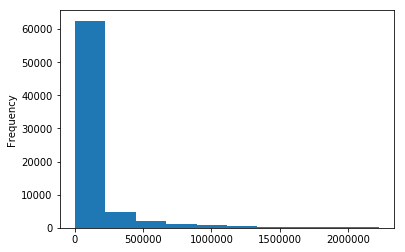

In [32]:
y = df['Views']
y.plot.hist()

In [33]:
from sklearn.model_selection import train_test_split
#print(df_scaled)
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, test_size=.2, random_state=205)

In [34]:
#XGB Boost regression
import xgboost as xgb
from sklearn import metrics
xlf = xgb.XGBRegressor()
xlf.fit(X_train, y_train, eval_metric='rmse', verbose = True, eval_set = [(X_test, y_test)])
# calculate the auc score
y_pred = xlf.predict(X_test)
#RMSE - Test
print("XGBoost - Linear regression: ", np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

[13:25:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:273316
[1]	validation_0-rmse:249805
[2]	validation_0-rmse:228759
[3]	validation_0-rmse:210340
[4]	validation_0-rmse:194034
[5]	validation_0-rmse:179827
[6]	validation_0-rmse:167359
[7]	validation_0-rmse:156384


D:\Applns\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[8]	validation_0-rmse:146807
[9]	validation_0-rmse:138529
[10]	validation_0-rmse:131366
[11]	validation_0-rmse:125279
[12]	validation_0-rmse:120053
[13]	validation_0-rmse:115627
[14]	validation_0-rmse:111711
[15]	validation_0-rmse:108504
[16]	validation_0-rmse:105962
[17]	validation_0-rmse:103723
[18]	validation_0-rmse:101898
[19]	validation_0-rmse:100275
[20]	validation_0-rmse:99008.9
[21]	validation_0-rmse:97869.4
[22]	validation_0-rmse:96926.8
[23]	validation_0-rmse:96110.7
[24]	validation_0-rmse:95489.4
[25]	validation_0-rmse:94885.7
[26]	validation_0-rmse:94419.7
[27]	validation_0-rmse:94013.2
[28]	validation_0-rmse:93624.2
[29]	validation_0-rmse:93355.5
[30]	validation_0-rmse:93124.2
[31]	validation_0-rmse:92839.4
[32]	validation_0-rmse:92623.3
[33]	validation_0-rmse:92359.1
[34]	validation_0-rmse:92200
[35]	validation_0-rmse:92081.5
[36]	validation_0-rmse:91931
[37]	validation_0-rmse:91808.9
[38]	validation_0-rmse:91687.4
[39]	validation_0-rmse:91613.2
[40]	validation_0-rmse:914

In [35]:
import pandas as pd
# In[83]:
test_df = pd.read_csv('D:\Hackathon\MachineHack - Music\Data_Test.csv')
test_df.head(10)
print(test_df.shape)

(19615, 10)


In [36]:
#Replace K, M, B
def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    if 'B' in x:
        return float(x.replace('B', '')) * 1000000000
    if ',' in x:
        return float(x.replace(',', '')) 
    return float(x)

test_df.Likes = test_df.Likes.apply(value_to_float)
test_df.Popularity = test_df.Popularity.apply(value_to_float)

In [37]:
#Correlation matrix
test_df.drop(['Unique_ID','Country','Timestamp','Song_Name','Comments','Followers'],inplace = True, axis = 1)
test_df.head()


,Name,Genre,Likes,Popularity
0,L2Share♫79,all-music,5428.0,118.0
1,Morgan Page,danceedm,738.0,195.0
2,Dirty Workz,danceedm,386.0,96.0
3,Gucci Mane,all-music,388.0,19.0
4,Angga Kecap,rock,79.0,1.0


In [38]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
# Converting Genre and Name to labelencoding
labelencoder = LabelEncoder()
test_df['Genre'] = labelencoder.fit_transform(test_df['Genre'])
test_df['Name'] = labelencoder.fit_transform(test_df['Name'])
test_df.head()


,Name,Genre,Likes,Popularity
0,487,0,5428.0,118.0
1,604,5,738.0,195.0
2,235,5,386.0,96.0
3,350,0,388.0,19.0
4,53,19,79.0,1.0


In [39]:
#Standard scaling
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
features = [x for x in test_df.columns if x not in ['Views']]
test_df_scaled = sc_x.fit_transform(test_df[features])
test_df_scaled = pd.DataFrame(test_df_scaled)
print(test_df_scaled.head())

          0         1         2         3
0 -0.238577 -1.472236 -0.068006 -0.166740
1  0.139991 -0.629021 -0.158250 -0.151475
2 -1.053953 -0.629021 -0.165023 -0.171102
3 -0.681857 -1.472236 -0.164984 -0.186368
4 -1.642837  1.731980 -0.170930 -0.189936


D:\Applns\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Applns\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [41]:
# calculate the auc score
y_pred_1 = xlf.predict(test_df_scaled)
y_pred_1 = pd.DataFrame(y_pred_1)
y_pred_1.to_csv('Data_Test_Predicted_Label_Encoder_Z_Score_XG_Boost_V_L_P.csv',sep='#')